In [ ]:
!git clone https://github.com/xuexingyu24/License_Plate_Detection_Pytorch.git

In [ ]:
!unzip /content/drive/MyDrive/CCPD2020.zip

In [ ]:
!tar -xvf "/content/drive/MyDrive/CCPD2019.tar.xz" -C "/content/"

## train_data preprocessing

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 12 09:37:49 2019

@author: xingyu
"""

"""
    generate positive, negative, positive images whose size are 12*47 and feed into PNet
"""
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
import cv2
import random
import os
import numpy as np
from utils.util import*
from imutils import paths

img_dir = "/content/CCPD2020/ccpd_green/train"
pos_save_dir = "/content/data_set/train/12/positive"
part_save_dir = "/content/data_set/train/12/part"
neg_save_dir = "/content/data_set/train/12/negative"

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)

label_dir = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store'
os.makedirs(label_dir)
# store labels of positive, negative, part images
f1 = open(os.path.join(label_dir, 'pos_12_train.txt'), 'w')
f2 = open(os.path.join(label_dir, 'neg_12_train.txt'), 'w')
f3 = open(os.path.join(label_dir, 'part_12_train.txt'), 'w')

img_paths = []
img_paths += [el for el in paths.list_images(img_dir)]
random.shuffle(img_paths)
num = len(img_paths)
print("%d pics in total" % num)

p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0
for annotation in img_paths:
    im_path = annotation
    print(im_path)
    
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)
    imgname_split = imgname.split('-')
    rec_x1y1 = imgname_split[2].split('_')[0].split('&')
    rec_x2y2 = imgname_split[2].split('_')[1].split('&')  
    x1, y1, x2, y2 = int(rec_x1y1[0]), int(rec_x1y1[1]), int(rec_x2y2[0]), int(rec_x2y2[1])
    
    boxes = np.zeros((1,4), dtype=np.int32)
    boxes[0,0], boxes[0,1], boxes[0,2], boxes[0,3] = x1, y1, x2, y2
    
    img = cv2.imread(im_path)
    idx += 1

    height, width, channel = img.shape
    
    neg_num = 0
    while neg_num < 35:
        size_x = np.random.randint(47, min(width, height) / 2)
        size_y = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size_x)
        ny = np.random.randint(0, height - size_y)
        crop_box = np.array([nx, ny, nx + size_x, ny + size_y])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size_y, nx: nx + size_x, :]
        resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1
            
    for box in boxes:
        # box (x_left, y_top, w, h)
        x1, y1, x2, y2 = box
        w = x2 - x1 + 1
        h = y2 - y1 + 1

        # generate negative examples that have overlap with gt
        for i in range(5):
            size_x = np.random.randint(47, min(width, height) / 2)
            size_y = np.random.randint(12, min(width, height) / 2)
            # delta_x and delta_y are offsets of (x1, y1)
            delta_x = np.random.randint(max(-size_x, -x1), w)
            delta_y = np.random.randint(max(-size_y, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size_x > width or ny1 + size_y > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size_x, ny1 + size_y])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size_y, nx1: nx1 + size_x, :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
        # generate positive examples and part faces
        for i in range(20):
            size_x = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
            size_y = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size_x / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size_y / 2, 0)
            nx2 = nx1 + size_x
            ny2 = ny1 + size_y

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size_x)
            offset_y1 = (y1 - ny1) / float(size_y)
            offset_x2 = (x2 - nx2) / float(size_x)
            offset_y2 = (y2 - ny2) / float(size_y)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
            elif IoU(crop_box, box_) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1



    print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

f1.close()
f2.close()
f3.close()
        

In [ ]:
"""
    generate positive, negative, positive images whose size are 24*24 from Pnet and feed into RNet
"""
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
import cv2
import os
import numpy as np
from utils.util import*
import torch
import random
from imutils import paths
from MTCNN import create_mtcnn_net

img_dir = "/content/CCPD2020/ccpd_green/train"
pos_save_dir = "/content/data_set/train/24/positive"
part_save_dir = "/content/data_set/train/24/part"
neg_save_dir = "/content/data_set/train/24/negative"

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)

label_dir = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store'
# store labels of positive, negative, part images
f1 = open(os.path.join(label_dir, 'pos_24_train.txt'), 'w')
f2 = open(os.path.join(label_dir, 'neg_24_train.txt'), 'w')
f3 = open(os.path.join(label_dir, 'part_24_train.txt'), 'w')

# anno_file: store labels of the wider face training data
img_paths = []
img_paths += [el for el in paths.list_images(img_dir)]
random.shuffle(img_paths)
num = len(img_paths)
print("%d pics in total" % num)

image_size = (94, 24)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0
for annotation in img_paths:
    im_path = annotation
    print(im_path)
    
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)
    imgname_split = imgname.split('-')
    rec_x1y1 = imgname_split[2].split('_')[0].split('&')
    rec_x2y2 = imgname_split[2].split('_')[1].split('&')  
    x1, y1, x2, y2 = int(rec_x1y1[0]), int(rec_x1y1[1]), int(rec_x2y2[0]), int(rec_x2y2[1])
    
    boxes = np.zeros((1,4), dtype=np.int32)
    boxes[0,0], boxes[0,1], boxes[0,2], boxes[0,3] = x1, y1, x2, y2

    image = cv2.imread(im_path)

    bboxes = create_mtcnn_net(image, [50,50], device, p_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/pnet_Weights', o_model_path=None)
    dets = np.round(bboxes[:, 0:4])

    if dets.shape[0] == 0:
        continue

    img = cv2.imread(im_path)
    idx += 1

    height, width, channel = img.shape

    for box in dets:
        x_left, y_top, x_right, y_bottom = box[0:4].astype(int)
        width = x_right - x_left + 1
        height = y_bottom - y_top + 1

        # ignore box that is too small or beyond image border
        if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
            continue

        # compute intersection over union(IoU) between current box and all gt boxes
        Iou = IoU(box, boxes)
        cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
        resized_im = cv2.resize(cropped_im, image_size, interpolation=cv2.INTER_LINEAR)

        # save negative images and write label
        if np.max(Iou) < 0.3 and n_idx < 3.2*p_idx+1:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
        else:
            # find gt_box with the highest iou
            idx_Iou = np.argmax(Iou)
            assigned_gt = boxes[idx_Iou]
            x1, y1, x2, y2 = assigned_gt

            # compute bbox reg label
            offset_x1 = (x1 - x_left) / float(width)
            offset_y1 = (y1 - y_top) / float(height)
            offset_x2 = (x2 - x_right) / float(width)
            offset_y2 = (y2 - y_bottom) / float(height)

            # save positive and part-face images and write labels
            if np.max(Iou) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1

            elif np.max(Iou) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1

    print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

f1.close()
f2.close()
f3.close()

In [ ]:
import os
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing')
import assemble

pnet_postive_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/pos_12_train.txt'
pnet_part_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/part_12_train.txt'
pnet_neg_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/neg_12_train.txt'
# pnet_landmark_file = './anno_store/landmark_12.txt'
imglist_filename = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_12_train.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(pnet_postive_file)
    anno_list.append(pnet_part_file)
    anno_list.append(pnet_neg_file)
    # anno_list.append(pnet_landmark_file)

    chose_count = assemble.assemble_data(imglist_filename ,anno_list)
    print("PNet train annotation result file path:%s" % imglist_filename)


In [ ]:
import os
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing')
import assemble

onet_postive_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/pos_24_train.txt'
onet_part_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/part_24_train.txt'
onet_neg_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/neg_24_train.txt'
# pnet_landmark_file = './anno_store/landmark_12.txt'
imglist_filename = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_24_train.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(onet_postive_file)
    anno_list.append(onet_part_file)
    anno_list.append(onet_neg_file)

    chose_count = assemble.assemble_data(imglist_filename ,anno_list)
    print("RNet train annotation result file path:%s" % imglist_filename)

##Validation_data preprocessing

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 12 09:37:49 2019

@author: xingyu
"""

"""
    generate positive, negative, positive images whose size are 12*47 and feed into PNet
"""
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
import cv2
import random
import os
import numpy as np
from utils.util import*
from imutils import paths

img_dir = "/content/CCPD2020/ccpd_green/val"
pos_save_dir = "/content/data_set/val/12/positive"
part_save_dir = "/content/data_set/val/12/part"
neg_save_dir = "/content/data_set/val/12/negative"

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)

label_dir = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store'
# store labels of positive, negative, part images
f1 = open(os.path.join(label_dir, 'pos_12_val.txt'), 'w')
f2 = open(os.path.join(label_dir, 'neg_12_val.txt'), 'w')
f3 = open(os.path.join(label_dir, 'part_12_val.txt'), 'w')

img_paths = []
img_paths += [el for el in paths.list_images(img_dir)]
random.shuffle(img_paths)
num = len(img_paths)
print("%d pics in total" % num)

p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0
for annotation in img_paths:
    im_path = annotation
    print(im_path)
    
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)
    imgname_split = imgname.split('-')
    rec_x1y1 = imgname_split[2].split('_')[0].split('&')
    rec_x2y2 = imgname_split[2].split('_')[1].split('&')  
    x1, y1, x2, y2 = int(rec_x1y1[0]), int(rec_x1y1[1]), int(rec_x2y2[0]), int(rec_x2y2[1])
    
    boxes = np.zeros((1,4), dtype=np.int32)
    boxes[0,0], boxes[0,1], boxes[0,2], boxes[0,3] = x1, y1, x2, y2
    
    img = cv2.imread(im_path)
    idx += 1

    height, width, channel = img.shape
    
    neg_num = 0
    while neg_num < 35:
        size_x = np.random.randint(47, min(width, height) / 2)
        size_y = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size_x)
        ny = np.random.randint(0, height - size_y)
        crop_box = np.array([nx, ny, nx + size_x, ny + size_y])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size_y, nx: nx + size_x, :]
        resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1
            
    for box in boxes:
        # box (x_left, y_top, w, h)
        x1, y1, x2, y2 = box
        w = x2 - x1 + 1
        h = y2 - y1 + 1

        # generate negative examples that have overlap with gt
        for i in range(5):
            size_x = np.random.randint(47, min(width, height) / 2)
            size_y = np.random.randint(12, min(width, height) / 2)
            # delta_x and delta_y are offsets of (x1, y1)
            delta_x = np.random.randint(max(-size_x, -x1), w)
            delta_y = np.random.randint(max(-size_y, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size_x > width or ny1 + size_y > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size_x, ny1 + size_y])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size_y, nx1: nx1 + size_x, :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
        # generate positive examples and part faces
        for i in range(20):
            size_x = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
            size_y = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size_x / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size_y / 2, 0)
            nx2 = nx1 + size_x
            ny2 = ny1 + size_y

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size_x)
            offset_y1 = (y1 - ny1) / float(size_y)
            offset_x2 = (x2 - nx2) / float(size_x)
            offset_y2 = (y2 - ny2) / float(size_y)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (47, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
            elif IoU(crop_box, box_) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1



    print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

f1.close()
f2.close()
f3.close()
        

In [ ]:
"""
    generate positive, negative, positive images whose size are 24*24 from Pnet and feed into RNet
"""
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
import cv2
import os
import numpy as np
from utils.util import*
import torch
import random
from imutils import paths
from MTCNN import create_mtcnn_net

img_dir = "/content/CCPD2020/ccpd_green/val"
pos_save_dir = "/content/data_set/val/24/positive"
part_save_dir = "/content/data_set/val/24/part"
neg_save_dir = "/content/data_set/val/24/negative"

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)

label_dir = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store'
# store labels of positive, negative, part images
f1 = open(os.path.join(label_dir, 'pos_24_val.txt'), 'w')
f2 = open(os.path.join(label_dir, 'neg_24_val.txt'), 'w')
f3 = open(os.path.join(label_dir, 'part_24_val.txt'), 'w')

# anno_file: store labels of the wider face training data
img_paths = []
img_paths += [el for el in paths.list_images(img_dir)]
random.shuffle(img_paths)
num = len(img_paths)
print("%d pics in total" % num)

image_size = (94, 24)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0
for annotation in img_paths:
    im_path = annotation
    print(im_path)
    
    basename = os.path.basename(im_path)
    imgname, suffix = os.path.splitext(basename)
    imgname_split = imgname.split('-')
    rec_x1y1 = imgname_split[2].split('_')[0].split('&')
    rec_x2y2 = imgname_split[2].split('_')[1].split('&')  
    x1, y1, x2, y2 = int(rec_x1y1[0]), int(rec_x1y1[1]), int(rec_x2y2[0]), int(rec_x2y2[1])
    
    boxes = np.zeros((1,4), dtype=np.int32)
    boxes[0,0], boxes[0,1], boxes[0,2], boxes[0,3] = x1, y1, x2, y2

    image = cv2.imread(im_path)

    bboxes = create_mtcnn_net(image, [50,50], device, p_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/pnet_Weights', o_model_path=None)
    dets = np.round(bboxes[:, 0:4])

    if dets.shape[0] == 0:
        continue

    img = cv2.imread(im_path)
    idx += 1

    height, width, channel = img.shape

    for box in dets:
        x_left, y_top, x_right, y_bottom = box[0:4].astype(int)
        width = x_right - x_left + 1
        height = y_bottom - y_top + 1

        # ignore box that is too small or beyond image border
        if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
            continue

        # compute intersection over union(IoU) between current box and all gt boxes
        Iou = IoU(box, boxes)
        cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
        resized_im = cv2.resize(cropped_im, image_size, interpolation=cv2.INTER_LINEAR)

        # save negative images and write label
        if np.max(Iou) < 0.3 and n_idx < 3.2*p_idx+1:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
        else:
            # find gt_box with the highest iou
            idx_Iou = np.argmax(Iou)
            assigned_gt = boxes[idx_Iou]
            x1, y1, x2, y2 = assigned_gt

            # compute bbox reg label
            offset_x1 = (x1 - x_left) / float(width)
            offset_y1 = (y1 - y_top) / float(height)
            offset_x2 = (x2 - x_right) / float(width)
            offset_y2 = (y2 - y_bottom) / float(height)

            # save positive and part-face images and write labels
            if np.max(Iou) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1

            elif np.max(Iou) >= 0.4 and d_idx < 1.2*p_idx + 1:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1

    print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

f1.close()
f2.close()
f3.close()

In [ ]:
import os
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing')
import assemble

pnet_postive_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/pos_12_val.txt'
pnet_part_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/part_12_val.txt'
pnet_neg_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/neg_12_val.txt'
# pnet_landmark_file = './anno_store/landmark_12.txt'
imglist_filename = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_12_val.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(pnet_postive_file)
    anno_list.append(pnet_part_file)
    anno_list.append(pnet_neg_file)
    # anno_list.append(pnet_landmark_file)

    chose_count = assemble.assemble_data(imglist_filename ,anno_list)
    print("PNet train annotation result file path:%s" % imglist_filename)


In [ ]:
import os
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing')
import assemble

onet_postive_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/pos_24_val.txt'
onet_part_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/part_24_val.txt'
onet_neg_file = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/neg_24_val.txt'
# pnet_landmark_file = './anno_store/landmark_12.txt'
imglist_filename = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_24_val.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(onet_postive_file)
    anno_list.append(onet_part_file)
    anno_list.append(onet_neg_file)

    chose_count = assemble.assemble_data(imglist_filename ,anno_list)
    print("RNet train annotation result file path:%s" % imglist_filename)

## training

In [ ]:
import sys
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/train')
import os 
import torch
from torch.utils.data import Dataset
from Data_Loading import ListDataset
from model.MTCNN_nets import PNet
import time
import copy
import torch.nn as nn

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)

train_path = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_12_train.txt'
val_path = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_12_val.txt'
batch_size = 64
dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(train_path), batch_size=batch_size, shuffle=True),
               'val': torch.utils.data.DataLoader(ListDataset(val_path), batch_size=batch_size, shuffle=True)}
dataset_sizes = {'train': len(ListDataset(train_path)), 'val': len(ListDataset(val_path))}
print('training dataset loaded with length : {}'.format(len(ListDataset(train_path))))
print('validation dataset loaded with length : {}'.format(len(ListDataset(val_path))))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# load the model and weights for initialization
model = PNet(is_train=True).to(device)
model.apply(weights_init)
print("Pnet loaded")

train_logging_file = 'Pnet_train_logging.txt'

optimizer = torch.optim.Adam(model.parameters())
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
best_loss = 100

loss_cls = nn.CrossEntropyLoss()
loss_offset = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set model to training mode
        else:
            model.eval()  # set model to evaluate mode

        running_loss, running_loss_cls, running_loss_offset = 0.0, 0.0, 0.0
        running_correct = 0.0
        running_gt = 0.0

        # iterate over data
        for i_batch, sample_batched in enumerate(dataloaders[phase]):

            input_images, gt_label, gt_offset = sample_batched['input_img'], sample_batched[
                'label'], sample_batched['bbox_target']
            input_images = input_images.to(device)
            gt_label = gt_label.to(device)
            # print('gt_label is ', gt_label)
            gt_offset = gt_offset.type(torch.FloatTensor).to(device)
            # print('gt_offset shape is ',gt_offset.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                pred_offsets, pred_label = model(input_images)
                pred_offsets = torch.squeeze(pred_offsets)
                pred_label = torch.squeeze(pred_label)
                # calculate the cls loss
                # get the mask element which >= 0, only 0 and 1 can effect the detection loss
                mask_cls = torch.ge(gt_label, 0)
                valid_gt_label = gt_label[mask_cls]
                valid_pred_label = pred_label[mask_cls]

                # calculate the box loss
                # get the mask element which != 0
                unmask = torch.eq(gt_label, 0)
                mask_offset = torch.eq(unmask, 0)
                valid_gt_offset = gt_offset[mask_offset]
                valid_pred_offset = pred_offsets[mask_offset]

                loss = torch.tensor(0.0).to(device)
                cls_loss, offset_loss = 0.0, 0.0
                eval_correct = 0.0
                num_gt = len(valid_gt_label)

                if len(valid_gt_label) != 0:
                    loss += 0.02*loss_cls(valid_pred_label, valid_gt_label)
                    cls_loss = loss_cls(valid_pred_label, valid_gt_label).item()
                    pred = torch.max(valid_pred_label, 1)[1]
                    eval_correct = (pred == valid_gt_label).sum().item()

                if len(valid_gt_offset) != 0:
                    loss += 0.6*loss_offset(valid_pred_offset, valid_gt_offset)
                    offset_loss = loss_offset(valid_pred_offset, valid_gt_offset).item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()*batch_size
                running_loss_cls += cls_loss*batch_size
                running_loss_offset += offset_loss*batch_size
                running_correct += eval_correct
                running_gt += num_gt

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_loss_cls = running_loss_cls / dataset_sizes[phase]
        epoch_loss_offset = running_loss_offset / dataset_sizes[phase]
        epoch_accuracy = running_correct / (running_gt + 1e-16)

        print('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
              .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset))
        with open(train_logging_file, 'a') as f:
            f.write('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
                    .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset)+'\n')
        f.close()

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best loss: {:4f}'.format(best_loss))

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'pnet_Weights')

training dataset loaded with length : 239153
validation dataset loaded with length : 42626
Pnet loaded
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.0081 accuracy: 0.9905 cls Loss: 0.0346 offset Loss: 0.0124
val Loss: 0.0079 accuracy: 0.9862 cls Loss: 0.0361 offset Loss: 0.0119
Epoch 1/49
----------
train Loss: 0.0046 accuracy: 0.9962 cls Loss: 0.0121 offset Loss: 0.0072
val Loss: 0.0088 accuracy: 0.9879 cls Loss: 0.0329 offset Loss: 0.0135
Epoch 2/49
----------
train Loss: 0.0036 accuracy: 0.9979 cls Loss: 0.0069 offset Loss: 0.0057
val Loss: 0.0099 accuracy: 0.9833 cls Loss: 0.0648 offset Loss: 0.0144
Epoch 3/49
----------
train Loss: 0.0031 accuracy: 0.9984 cls Loss: 0.0051 offset Loss: 0.0050
val Loss: 0.0064 accuracy: 0.9921 cls Loss: 0.0282 offset Loss: 0.0098
Epoch 4/49
----------
train Loss: 0.0028 accuracy: 0.9987 cls Loss: 0.0044 offset Loss: 0.0046
val Loss: 0.0059 accuracy: 0.9920 cls Loss: 0.0308 offset Loss: 0.0088
Epoch 5/49
----------
train Loss: 0.0026 accuracy: 0.9989 cls Loss: 0.0037 offset Loss: 0.0042
val Loss: 0.0071 accuracy: 0.9908 cls Loss: 0.0444 offset Loss: 0.0104
Epoch 6/49
----------
trai

In [ ]:
import sys
sys.path.append('..')
import os 
import torch
from torch.utils.data import Dataset
from Data_Loading import ListDataset
from model.MTCNN_nets import ONet
import time
import copy
import torch.nn as nn

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)

train_path = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_24_train.txt'
val_path = '/content/License_Plate_Detection_Pytorch/MTCNN/data_preprocessing/anno_store/imglist_anno_24_val.txt'
batch_size = 128
dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(train_path), batch_size=batch_size, shuffle=True),
               'val': torch.utils.data.DataLoader(ListDataset(val_path), batch_size=batch_size, shuffle=True)}
dataset_sizes = {'train': len(ListDataset(train_path)), 'val': len(ListDataset(val_path))}
print('training dataset loaded with length : {}'.format(len(ListDataset(train_path))))
print('validation dataset loaded with length : {}'.format(len(ListDataset(val_path))))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# load the model and weights for initialization
model = ONet(is_train=True).to(device)
model.apply(weights_init)
print("Onet loaded")

train_logging_file = 'Onet_train_logging.txt'

optimizer = torch.optim.Adam(model.parameters())
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
best_loss = 100

loss_cls = nn.CrossEntropyLoss()
loss_offset = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set model to training mode
        else:
            model.eval()  # set model to evaluate mode

        running_loss, running_loss_cls, running_loss_offset = 0.0, 0.0, 0.0
        running_correct = 0.0
        running_gt = 0.0

        # iterate over data
        for i_batch, sample_batched in enumerate(dataloaders[phase]):

            input_images, gt_label, gt_offset = sample_batched['input_img'], sample_batched[
                'label'], sample_batched['bbox_target']
            input_images = input_images.to(device)
            gt_label = gt_label.to(device)
            # print('gt_label is ', gt_label)
            gt_offset = gt_offset.type(torch.FloatTensor).to(device)
            # print('gt_offset shape is ',gt_offset.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                pred_offsets, pred_label = model(input_images)
                pred_offsets = torch.squeeze(pred_offsets)
                pred_label = torch.squeeze(pred_label)
                # calculate the cls loss
                # get the mask element which >= 0, only 0 and 1 can effect the detection loss
                mask_cls = torch.ge(gt_label, 0)
                valid_gt_label = gt_label[mask_cls]
                valid_pred_label = pred_label[mask_cls]

                # calculate the box loss
                # get the mask element which != 0
                unmask = torch.eq(gt_label, 0)
                mask_offset = torch.eq(unmask, 0)
                valid_gt_offset = gt_offset[mask_offset]
                valid_pred_offset = pred_offsets[mask_offset]

                loss = torch.tensor(0.0).to(device)
                cls_loss, offset_loss = 0.0, 0.0
                eval_correct = 0.0
                num_gt = len(valid_gt_label)

                if len(valid_gt_label) != 0:
                    loss += 0.02*loss_cls(valid_pred_label, valid_gt_label)
                    cls_loss = loss_cls(valid_pred_label, valid_gt_label).item()
                    pred = torch.max(valid_pred_label, 1)[1]
                    eval_correct = (pred == valid_gt_label).sum().item()

                if len(valid_gt_offset) != 0:
                    loss += 0.6*loss_offset(valid_pred_offset, valid_gt_offset)
                    offset_loss = loss_offset(valid_pred_offset, valid_gt_offset).item()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()*batch_size
                running_loss_cls += cls_loss*batch_size
                running_loss_offset += offset_loss*batch_size
                running_correct += eval_correct
                running_gt += num_gt

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_loss_cls = running_loss_cls / dataset_sizes[phase]
        epoch_loss_offset = running_loss_offset / dataset_sizes[phase]
        epoch_accuracy = running_correct / (running_gt + 1e-16)

        print('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
              .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset))
        with open(train_logging_file, 'a') as f:
            f.write('{} Loss: {:.4f} accuracy: {:.4f} cls Loss: {:.4f} offset Loss: {:.4f}'
                    .format(phase, epoch_loss, epoch_accuracy, epoch_loss_cls, epoch_loss_offset)+'\n')
        f.close()

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best loss: {:4f}'.format(best_loss))

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'onet_Weights')

training dataset loaded with length : 22358
validation dataset loaded with length : 2130
Onet loaded
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.0339 accuracy: 0.8501 cls Loss: 0.3398 offset Loss: 0.0452
val Loss: 0.0107 accuracy: 0.9511 cls Loss: 0.1604 offset Loss: 0.0125
Epoch 1/49
----------
train Loss: 0.0081 accuracy: 0.9725 cls Loss: 0.0923 offset Loss: 0.0104
val Loss: 0.0117 accuracy: 0.9547 cls Loss: 0.1137 offset Loss: 0.0157
Epoch 2/49
----------
train Loss: 0.0057 accuracy: 0.9850 cls Loss: 0.0491 offset Loss: 0.0079
val Loss: 0.0082 accuracy: 0.9843 cls Loss: 0.0487 offset Loss: 0.0121
Epoch 3/49
----------
train Loss: 0.0044 accuracy: 0.9915 cls Loss: 0.0291 offset Loss: 0.0063
val Loss: 0.0083 accuracy: 0.9789 cls Loss: 0.0478 offset Loss: 0.0123
Epoch 4/49
----------
train Loss: 0.0037 accuracy: 0.9939 cls Loss: 0.0203 offset Loss: 0.0056
val Loss: 0.0078 accuracy: 0.9734 cls Loss: 0.0639 offset Loss: 0.0109
Epoch 5/49
----------
train Loss: 0.0033 accuracy: 0.9956 cls Loss: 0.0151 offset Loss: 0.0050
val Loss: 0.0084 accuracy: 0.9879 cls Loss: 0.0292 offset Loss: 0.0131
Epoch 6/49
----------
trai

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f = open("/content/Onet_train_logging.txt","r")
lines = f.readlines()
train_acc = []
val_acc = []
train_loss = []
val_loss = []
for x in lines:
    # finding start point of data
    if x.split(' ')[0].strip() == "train":
        train_acc.append(float(x.split(' ')[4].strip()))
        train_loss.append(float(x.split(' ')[2].strip()))
    if x.split(' ')[0].strip() == "val":
        val_acc.append(float(x.split(' ')[4].strip()))
        val_loss.append(float(x.split(' ')[2].strip()))
f.close()

# train_acc = np.array(train_acc)
# val_acc = np.array(val_acc)
# print(train_acc- val_acc)

train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

AttributeError: ignored

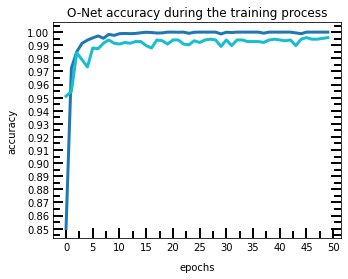

In [ ]:
# Import required packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm

from matplotlib import rcParams
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/content/Palatino Linotype.ttf']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Palatino Linotype'

# Generate 2 colors from the 'Set1' colormap
colors = cm.get_cmap('tab10', 2)

# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(4, 3))

# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

# Create new axes object by cloning the y-axis of the first plot
# ax2 = ax.twiny()

# Edit the major and minor ticks of the x and y axes
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

# Edit the tick parameters of the energy x-axis
# ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
# ax2.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')

# Plot the two sample absorbances, using previously generated colors
ax.plot(train_acc, linewidth=3, color=colors(0), label='training-set accuracy')
ax.plot(val_acc, linewidth=3, color=colors(1), label='validation-set accuracy')


# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

# Add ticks manually to energy axis
# ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(E_to_WL(np.linspace(1.5, 3.0, 4))))
# ax2.xaxis.set_minor_locator(mpl.ticker.FixedLocator(E_to_WL(np.linspace(1.4, 3.2, 19))))

# Add tick labels manually to energy axis
# ax2.set_xticklabels(['1.5', '2.0', '2.5', '3.0'])

# Add the x and y-axis labels
ax.set_xlabel(r'epochs', labelpad=10)
ax.set_ylabel('accuracy', labelpad=10)

ax.set_title(r'O-Net accuracy during the training process')

# Add energy axis label
# ax2.set_xlabel('Energy (eV)', labelpad=10)

# Set the axis limits
# ax.set_xlim(0, 100)
# ax.set_ylim(0.8, 1)

# Set the energy axis limits
# ax2.set_xlim(370, 930)

# Add legend to plot
ax.legend(bbox_to_anchor=(1, 0.4), loc=1, frameon=True, fontsize=16)

# Save figure
plt.savefig('MTCNN_accuracy_Plot.png', dpi=300, transparent=False, bbox_inches='tight')

# Show figure
plt.show()

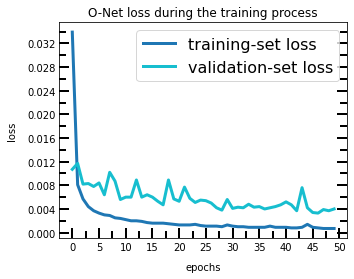

In [ ]:
# Import required packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm

from matplotlib import rcParams
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/content/Palatino Linotype.ttf']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Palatino Linotype'


# Generate 2 colors from the 'Set1' colormap
colors = cm.get_cmap('tab10', 2)

# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(4, 3))

# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

# Create new axes object by cloning the y-axis of the first plot
# ax2 = ax.twiny()

# Edit the major and minor ticks of the x and y axes
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

# Edit the tick parameters of the energy x-axis
# ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
# ax2.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')

# Plot the two sample absorbances, using previously generated colors
ax.plot(train_loss, linewidth=3, color=colors(0), label='training-set loss')
ax.plot(val_loss, linewidth=3, color=colors(1), label='validation-set loss')


# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.004))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.002))

# Add ticks manually to energy axis
# ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(E_to_WL(np.linspace(1.5, 3.0, 4))))
# ax2.xaxis.set_minor_locator(mpl.ticker.FixedLocator(E_to_WL(np.linspace(1.4, 3.2, 19))))

# Add tick labels manually to energy axis
# ax2.set_xticklabels(['1.5', '2.0', '2.5', '3.0'])

# Add the x and y-axis labels
ax.set_xlabel(r'epochs', labelpad=10)
ax.set_ylabel('loss', labelpad=10)

ax.set_title(r'O-Net loss during the training process')

# Add energy axis label
# ax2.set_xlabel('Energy (eV)', labelpad=10)

# Set the axis limits
# ax.set_xlim(0, 100)
# ax.set_ylim(0.8, 1)

# Set the energy axis limits
# ax2.set_xlim(370, 930)

# Add legend to plot
ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=16)

# Save figure
plt.savefig('MTCNN_loss_Plot.png', dpi=300, transparent=False, bbox_inches='tight')

# Show figure
plt.show()

## test

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


image predicted in 10.679 seconds


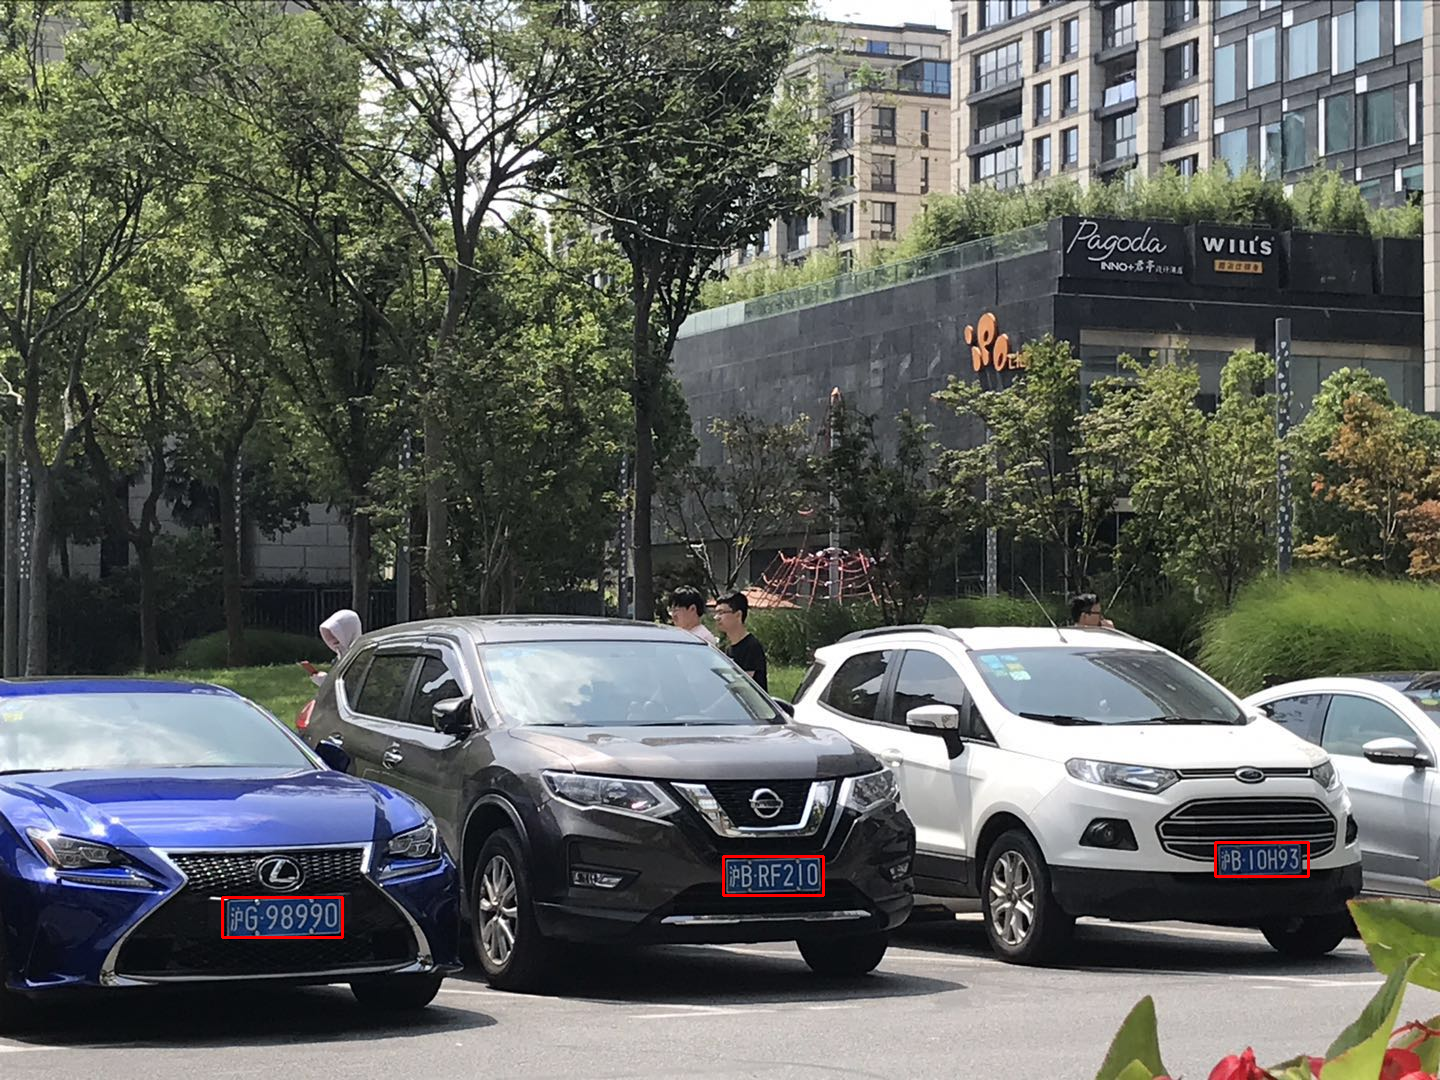

In [ ]:
import sys
import os
sys.path.append(os.getcwd())
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN/')
import argparse
import torch
from model.MTCNN_nets import PNet, ONet
import math
import numpy as np
from utils.util import *
import cv2
import time

def create_mtcnn_net(image, mini_lp_size, device, p_model_path=None, o_model_path=None):

    bboxes = np.array([])

    if p_model_path is not None:
        pnet = PNet().to(device)
        pnet.load_state_dict(torch.load(p_model_path, map_location=lambda storage, loc: storage))
        pnet.eval()

        bboxes = detect_pnet(pnet, image, mini_lp_size, device)

    if o_model_path is not None:
        onet = ONet().to(device)
        onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()

        bboxes = detect_onet(onet, image, bboxes, device)

    return bboxes

def detect_pnet(pnet, image, min_lp_size, device):

    # start = time.time()

    thresholds = 0.6 # lp detection thresholds
    nms_thresholds = 0.7

    # BUILD AN IMAGE PYRAMID
    height, width, channel = image.shape
    min_height, min_width = height, width

    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    factor_count = 0
    while min_height > min_lp_size[1] and min_width > min_lp_size[0]:
        scales.append(factor ** factor_count)
        min_height *= factor
        min_width *=factor
        factor_count += 1

    # it will be returned
    bounding_boxes = []

    with torch.no_grad():
        # run P-Net on different scales
        for scale in scales:
            sw, sh = math.ceil(width * scale), math.ceil(height * scale)
            img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
            img = torch.FloatTensor(preprocess(img)).to(device)
            offset, prob = pnet(img)
            probs = prob.cpu().data.numpy()[0, 1, :, :]  # probs: probability of a face at each sliding window
            offsets = offset.cpu().data.numpy()  # offsets: transformations to true bounding boxes
            # applying P-Net is equivalent, in some sense, to moving 12x12 window with stride 2
            stride, cell_size = (2,5), (12,44)
            # indices of boxes where there is probably a lp
            # returns a tuple with an array of row idx's, and an array of col idx's:
            inds = np.where(probs > thresholds)

            if inds[0].size == 0:
                boxes = None
            else:
                # transformations of bounding boxes
                tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
                offsets = np.array([tx1, ty1, tx2, ty2])
                score = probs[inds[0], inds[1]]
                # P-Net is applied to scaled images
                # so we need to rescale bounding boxes back
                bounding_box = np.vstack([
                    np.round((stride[1] * inds[1] + 1.0) / scale),
                    np.round((stride[0] * inds[0] + 1.0) / scale),
                    np.round((stride[1] * inds[1] + 1.0 + cell_size[1]) / scale),
                    np.round((stride[0] * inds[0] + 1.0 + cell_size[0]) / scale),
                    score, offsets])
                boxes = bounding_box.T
                keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
                boxes[keep]

            bounding_boxes.append(boxes)

        # collect boxes (and offsets, and scores) from different scales
        bounding_boxes = [i for i in bounding_boxes if i is not None]
        
        if bounding_boxes != []:
            bounding_boxes = np.vstack(bounding_boxes)
            keep = nms(bounding_boxes[:, 0:5], nms_thresholds)
            bounding_boxes = bounding_boxes[keep]
        else:
            bounding_boxes = np.zeros((1,9))
        # use offsets predicted by pnet to transform bounding boxes
        bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
        # shape [n_boxes, 5],  x1, y1, x2, y2, score

        bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

        # print("pnet predicted in {:2.3f} seconds".format(time.time() - start))

        return bboxes

def detect_onet(onet, image, bboxes, device):

    # start = time.time()

    size = (94,24)
    thresholds = 0.8  # face detection thresholds
    nms_thresholds = 0.7
    height, width, channel = image.shape

    num_boxes = len(bboxes)
    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

    img_boxes = np.zeros((num_boxes, 3, size[1], size[0]))

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3))

        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        # resize
        img_box = cv2.resize(img_box, size, interpolation=cv2.INTER_LINEAR)

        img_boxes[i, :, :, :] = preprocess(img_box)

    img_boxes = torch.FloatTensor(img_boxes).to(device)
    offset, prob = onet(img_boxes)
    offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
    probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds)[0]
    bboxes = bboxes[keep]
    bboxes[:, 4] = probs[keep, 1].reshape((-1,))  # assign score from stage 2
    offsets = offsets[keep]
    
    bboxes = calibrate_box(bboxes, offsets)
    keep = nms(bboxes, nms_thresholds, mode='min')
    bboxes = bboxes[keep]
    bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
    # print("onet predicted in {:2.3f} seconds".format(time.time() - start))

    return bboxes

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='MTCNN Demo')
    parser.add_argument("--test_image", dest='test_image', help="test image path", default="/content/License_Plate_Detection_Pytorch/test/1.jpg", type=str)
    parser.add_argument("--scale", dest='scale', help="scale the iamge", default=1, type=int)
    parser.add_argument('--mini_lp', dest='mini_lp', help="Minimum lp to be detected. derease to increase accuracy. Increase to increase speed",
                        default=(50, 15), type=int)

    args, unknown = parser.parse_known_args()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    image = cv2.imread(args.test_image)
    image = cv2.resize(image, (0, 0), fx = args.scale, fy = args.scale, interpolation=cv2.INTER_CUBIC)

    start = time.time()

    bboxes = create_mtcnn_net(image, args.mini_lp, device, p_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/pnet_Weights', o_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/onet_Weights')

    print("image predicted in {:2.3f} seconds".format(time.time() - start))

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i, :4]
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        
    image = cv2.resize(image, (0, 0), fx = 1/args.scale, fy = 1/args.scale, interpolation=cv2.INTER_CUBIC)
    from google.colab.patches import cv2_imshow
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(args.image)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 26 15:49:57 2019

@author: xingyu
"""
import sys
sys.path.append('./LPRNet')
sys.path.append('./MTCNN')
from LPRNet_Test import *
from MTCNN import *
import numpy as np
import argparse
import torch
import time
import cv2

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='MTCNN & LPR Demo')
    parser.add_argument("-image", help='image path', default='test/8.jpg', type=str)
    parser.add_argument("--scale", dest='scale', help="scale the iamge", default=1, type=int)
    parser.add_argument('--mini_lp', dest='mini_lp', help="Minimum face to be detected", default=(50, 15), type=int)
    args, unknown = parser.parse_known_args()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    lprnet = LPRNet(class_num=len(CHARS), dropout_rate=0)
    lprnet.to(device)
    lprnet.load_state_dict(torch.load('LPRNet/weights/Final_LPRNet_model.pth', map_location=lambda storage, loc: storage))
    lprnet.eval()
    
    STN = STNet()
    STN.to(device)
    STN.load_state_dict(torch.load('LPRNet/weights/Final_STN_model.pth', map_location=lambda storage, loc: storage))
    STN.eval()
    
    print("Successful to build LPR network!")
    
    since = time.time()
    image = cv2.imread(args.image)
    image = cv2.resize(image, (0, 0), fx = args.scale, fy = args.scale, interpolation=cv2.INTER_CUBIC)
    bboxes = create_mtcnn_net(image, args.mini_lp, device, p_model_path='MTCNN/weights/pnet_Weights', o_model_path='MTCNN/weights/onet_Weights')
    
    for i in range(bboxes.shape[0]):
         
        bbox = bboxes[i, :4]
        x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
        w = int(x2 - x1 + 1.0)
        h = int(y2 - y1 + 1.0)
        img_box = np.zeros((h, w, 3))
        img_box = image[y1:y2+1, x1:x2+1, :]
        im = cv2.resize(img_box, (94, 24), interpolation=cv2.INTER_CUBIC)
        im = (np.transpose(np.float32(im), (2, 0, 1)) - 127.5)*0.0078125
        data = torch.from_numpy(im).float().unsqueeze(0).to(device)  # torch.Size([1, 3, 24, 94]) 
        transfer = STN(data)
        preds = lprnet(transfer)
        preds = preds.cpu().detach().numpy()  # (1, 68, 18)    
        labels, pred_labels = decode(preds, CHARS)
    
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 1)
        image = cv2ImgAddText(image, labels[0], (x1, y1-12), textColor=(255, 255, 0), textSize=15)
    
    print("model inference in {:2.3f} seconds".format(time.time() - since))      
    image = cv2.resize(image, (0, 0), fx = 1/args.scale, fy = 1/args.scale, interpolation=cv2.INTER_CUBIC)
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#### save bounding boxes

image predicted in 0.226 seconds


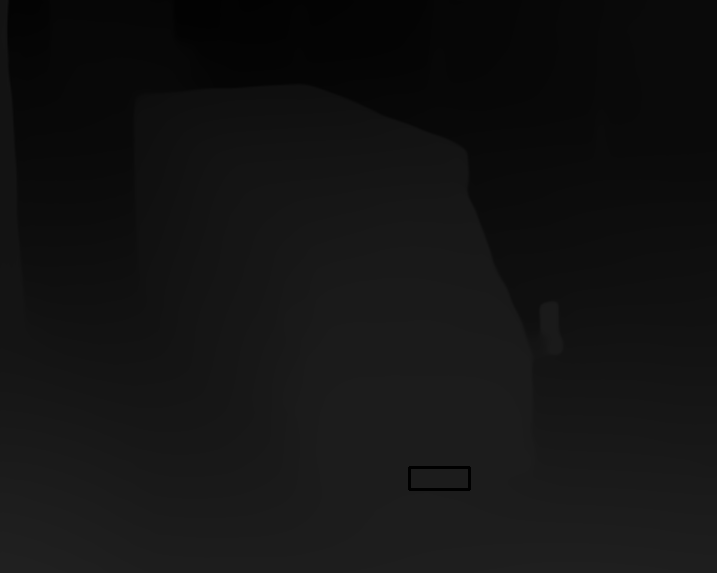

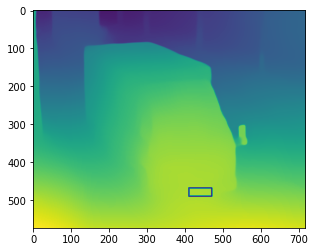

In [ ]:
import sys
import os
sys.path.append(os.getcwd())
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
import argparse
import torch
from model.MTCNN_nets import PNet, ONet
import math
import numpy as np
from utils.util import *
import cv2
import time

def create_mtcnn_net(image, mini_lp_size, device, p_model_path=None, o_model_path=None):

    bboxes = np.array([])

    if p_model_path is not None:
        pnet = PNet().to(device)
        pnet.load_state_dict(torch.load(p_model_path, map_location=lambda storage, loc: storage))
        pnet.eval()

        bboxes = detect_pnet(pnet, image, mini_lp_size, device)

    if o_model_path is not None:
        onet = ONet().to(device)
        onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()

        bboxes = detect_onet(onet, image, bboxes, device)

    return bboxes

def detect_pnet(pnet, image, min_lp_size, device):

    # start = time.time()

    thresholds = 0.6 # lp detection thresholds
    nms_thresholds = 0.7

    # BUILD AN IMAGE PYRAMID
    height, width, channel = image.shape
    min_height, min_width = height, width

    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    factor_count = 0
    while min_height > min_lp_size[1] and min_width > min_lp_size[0]:
        scales.append(factor ** factor_count)
        min_height *= factor
        min_width *=factor
        factor_count += 1

    # it will be returned
    bounding_boxes = []

    with torch.no_grad():
        # run P-Net on different scales
        for scale in scales:
            sw, sh = math.ceil(width * scale), math.ceil(height * scale)
            img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
            img = torch.FloatTensor(preprocess(img)).to(device)
            offset, prob = pnet(img)
            probs = prob.cpu().data.numpy()[0, 1, :, :]  # probs: probability of a face at each sliding window
            offsets = offset.cpu().data.numpy()  # offsets: transformations to true bounding boxes
            # applying P-Net is equivalent, in some sense, to moving 12x12 window with stride 2
            stride, cell_size = (2,5), (12,44)
            # indices of boxes where there is probably a lp
            # returns a tuple with an array of row idx's, and an array of col idx's:
            inds = np.where(probs > thresholds)

            if inds[0].size == 0:
                boxes = None
            else:
                # transformations of bounding boxes
                tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
                offsets = np.array([tx1, ty1, tx2, ty2])
                score = probs[inds[0], inds[1]]
                # P-Net is applied to scaled images
                # so we need to rescale bounding boxes back
                bounding_box = np.vstack([
                    np.round((stride[1] * inds[1] + 1.0) / scale),
                    np.round((stride[0] * inds[0] + 1.0) / scale),
                    np.round((stride[1] * inds[1] + 1.0 + cell_size[1]) / scale),
                    np.round((stride[0] * inds[0] + 1.0 + cell_size[0]) / scale),
                    score, offsets])
                boxes = bounding_box.T
                keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
                boxes[keep]

            bounding_boxes.append(boxes)

        # collect boxes (and offsets, and scores) from different scales
        bounding_boxes = [i for i in bounding_boxes if i is not None]
        
        if bounding_boxes != []:
            bounding_boxes = np.vstack(bounding_boxes)
            keep = nms(bounding_boxes[:, 0:5], nms_thresholds)
            bounding_boxes = bounding_boxes[keep]
        else:
            bounding_boxes = np.zeros((1,9))
        # use offsets predicted by pnet to transform bounding boxes
        bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
        # shape [n_boxes, 5],  x1, y1, x2, y2, score

        bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

        # print("pnet predicted in {:2.3f} seconds".format(time.time() - start))

        return bboxes

def detect_onet(onet, image, bboxes, device):

    # start = time.time()

    size = (94,24)
    thresholds = 0.8  # face detection thresholds
    nms_thresholds = 0.7
    height, width, channel = image.shape

    num_boxes = len(bboxes)
    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

    img_boxes = np.zeros((num_boxes, 3, size[1], size[0]))

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3))

        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        # resize
        img_box = cv2.resize(img_box, size, interpolation=cv2.INTER_LINEAR)

        img_boxes[i, :, :, :] = preprocess(img_box)

    img_boxes = torch.FloatTensor(img_boxes).to(device)
    offset, prob = onet(img_boxes)
    offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
    probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds)[0]
    bboxes = bboxes[keep]
    bboxes[:, 4] = probs[keep, 1].reshape((-1,))  # assign score from stage 2
    offsets = offsets[keep]
    
    bboxes = calibrate_box(bboxes, offsets)
    keep = nms(bboxes, nms_thresholds, mode='min')
    bboxes = bboxes[keep]
    bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
    # print("onet predicted in {:2.3f} seconds".format(time.time() - start))

    return bboxes

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='MTCNN Demo')
    parser.add_argument("--test_image", dest='test_image', help="test image path", default="/content/License_Plate_Detection_Pytorch/test/6.jpg", type=str)
    parser.add_argument("--scale", dest='scale', help="scale the iamge", default=1, type=int)
    parser.add_argument('--mini_lp', dest='mini_lp', help="Minimum lp to be detected. derease to increase accuracy. Increase to increase speed",
                        default=(50, 15), type=int)

    args, unknown = parser.parse_known_args()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    image = cv2.imread(args.test_image)
    image = cv2.resize(image, (0, 0), fx = args.scale, fy = args.scale, interpolation=cv2.INTER_CUBIC)

    start = time.time()

    bboxes = create_mtcnn_net(image, args.mini_lp, device, p_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/pnet_Weights', o_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/onet_Weights')

    print("image predicted in {:2.3f} seconds".format(time.time() - start))

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i, :4]
        cv2.rectangle(output, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
        
    image = cv2.resize(output, (0, 0), fx = 1/args.scale, fy = 1/args.scale, interpolation=cv2.INTER_CUBIC)
    from google.colab.patches import cv2_imshow
    cv2_imshow(output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    plt.imshow(output)

In [ ]:
import sys
import os
sys.path.append(os.getcwd())
import argparse
import torch
sys.path.append('/content/License_Plate_Detection_Pytorch/MTCNN')
from model.MTCNN_nets import PNet, ONet
import math
import numpy as np
from utils.util import *
import cv2
import time
import csv

def create_mtcnn_net(image, mini_lp_size, device, p_model_path=None, o_model_path=None):

    bboxes = np.array([])

    if p_model_path is not None:
        pnet = PNet().to(device)
        pnet.load_state_dict(torch.load(p_model_path, map_location=lambda storage, loc: storage))
        pnet.eval()

        bboxes = detect_pnet(pnet, image, mini_lp_size, device)

    if o_model_path is not None:
        onet = ONet().to(device)
        onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()

        bboxes = detect_onet(onet, image, bboxes, device)

    return bboxes

def detect_pnet(pnet, image, min_lp_size, device):

    # start = time.time()

    thresholds = 0.6 # lp detection thresholds
    nms_thresholds = 0.7

    # BUILD AN IMAGE PYRAMID
    height, width, channel = image.shape
    min_height, min_width = height, width

    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    factor_count = 0
    while min_height > min_lp_size[1] and min_width > min_lp_size[0]:
        scales.append(factor ** factor_count)
        min_height *= factor
        min_width *=factor
        factor_count += 1

    # it will be returned
    bounding_boxes = []

    with torch.no_grad():
        # run P-Net on different scales
        for scale in scales:
            sw, sh = math.ceil(width * scale), math.ceil(height * scale)
            img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
            img = torch.FloatTensor(preprocess(img)).to(device)
            offset, prob = pnet(img)
            probs = prob.cpu().data.numpy()[0, 1, :, :]  # probs: probability of a face at each sliding window
            offsets = offset.cpu().data.numpy()  # offsets: transformations to true bounding boxes
            # applying P-Net is equivalent, in some sense, to moving 12x12 window with stride 2
            stride, cell_size = (2,5), (12,44)
            # indices of boxes where there is probably a lp
            # returns a tuple with an array of row idx's, and an array of col idx's:
            inds = np.where(probs > thresholds)

            if inds[0].size == 0:
                boxes = None
            else:
                # transformations of bounding boxes
                tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
                offsets = np.array([tx1, ty1, tx2, ty2])
                score = probs[inds[0], inds[1]]
                # P-Net is applied to scaled images
                # so we need to rescale bounding boxes back
                bounding_box = np.vstack([
                    np.round((stride[1] * inds[1] + 1.0) / scale),
                    np.round((stride[0] * inds[0] + 1.0) / scale),
                    np.round((stride[1] * inds[1] + 1.0 + cell_size[1]) / scale),
                    np.round((stride[0] * inds[0] + 1.0 + cell_size[0]) / scale),
                    score, offsets])
                boxes = bounding_box.T
                keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
                boxes[keep]

            bounding_boxes.append(boxes)

        # collect boxes (and offsets, and scores) from different scales
        bounding_boxes = [i for i in bounding_boxes if i is not None]
        
        if bounding_boxes != []:
            bounding_boxes = np.vstack(bounding_boxes)
            keep = nms(bounding_boxes[:, 0:5], nms_thresholds)
            bounding_boxes = bounding_boxes[keep]
        else:
            bounding_boxes = np.zeros((1,9))
        # use offsets predicted by pnet to transform bounding boxes
        bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
        # shape [n_boxes, 5],  x1, y1, x2, y2, score

        bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

        # print("pnet predicted in {:2.3f} seconds".format(time.time() - start))

        return bboxes

def detect_onet(onet, image, bboxes, device):

    # start = time.time()

    size = (94,24)
    thresholds = 0.8  # face detection thresholds
    nms_thresholds = 0.7
    height, width, channel = image.shape

    num_boxes = len(bboxes)
    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

    img_boxes = np.zeros((num_boxes, 3, size[1], size[0]))

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3))

        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

        # resize
        img_box = cv2.resize(img_box, size, interpolation=cv2.INTER_LINEAR)

        img_boxes[i, :, :, :] = preprocess(img_box)

    img_boxes = torch.FloatTensor(img_boxes).to(device)
    offset, prob = onet(img_boxes)
    offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
    probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds)[0]
    bboxes = bboxes[keep]
    bboxes[:, 4] = probs[keep, 1].reshape((-1,))  # assign score from stage 2
    offsets = offsets[keep]
    
    bboxes = calibrate_box(bboxes, offsets)
    keep = nms(bboxes, nms_thresholds, mode='min')
    bboxes = bboxes[keep]
    bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
    # print("onet predicted in {:2.3f} seconds".format(time.time() - start))

    return bboxes

if __name__ == '__main__':
    allboxes = []
    for name in images_names:
        parser = argparse.ArgumentParser(description='MTCNN Demo')
        parser.add_argument("--test_image", dest='test_image', help="test image path", default="/content/License_Plate_Detection_Pytorch/test/" + str(name), type=str)
        parser.add_argument("--scale", dest='scale', help="scale the iamge", default=1, type=int)
        parser.add_argument('--mini_lp', dest='mini_lp', help="Minimum lp to be detected. derease to increase accuracy. Increase to increase speed",
                            default=(50, 15), type=int)

        args, unknown = parser.parse_known_args()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        image = cv2.imread(args.test_image)
        image = cv2.resize(image, (0, 0), fx = args.scale, fy = args.scale, interpolation=cv2.INTER_CUBIC)

        start = time.time()

        bboxes = create_mtcnn_net(image, args.mini_lp, device, p_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/pnet_Weights', o_model_path='/content/License_Plate_Detection_Pytorch/MTCNN/weights/onet_Weights')

        print("image predicted in {:2.3f} seconds".format(time.time() - start))

        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, :4]
            cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 2)
            x_min = int(float(bbox[0]))
            y_min = int(float(bbox[1]))
            x_max = int(float(bbox[2]))
            y_max = int(float(bbox[3]))
            # box_distances = x_max - x_min
            # bb = [bbox[0],bbox[1],bbox[2],bbox[3],200/box_distances]
            print("/content/License_Plate_Detection_Pytorch/test/" + str(name))
            with torch.no_grad():
                prediction = midas(input_batch)

                prediction = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size=image.shape[:2],
                    mode="bicubic",
                    align_corners=False,
                ).squeeze()
                
            output = prediction.cpu().numpy()
            # print(output)

            box_distances = output[int(bbox[1]),int(bbox[0])]
            print(box_distances)

            bb = [bbox[0],bbox[1],bbox[2],bbox[3],200/box_distances]
            allboxes.append(bb)

